# Off-Manifold Detection with Topology (Persistent Homology) Scores (Two Moons)

This notebook evaluates **topology-driven adversarial detection** on the two-moons dataset.

## Conceptual methodology (what we are doing)

We treat clean data as lying near a structured set in a representation space \(z=\phi(x)\) (either **input space** or **model feature space**).

- **Reference structure**: local neighborhoods of the training set approximate the clean data’s local topology.
- **Topology features (PH)**: for each test point, we form a local neighborhood point cloud and compute **persistent homology** (typically H0/H1) and summarize the persistence diagrams (counts, total/max persistence, entropy, etc.).
- **Detector score**: we fit a clean reference distribution over topology feature vectors, then score points by their deviation from that reference (Mahalanobis distance) and threshold at a clean percentile.

## Notes

- Neighborhood geometry is used only to define the local patch/filtration for PH; the *detection statistic* is derived from topology features.
- Purely on-manifold label-flip attacks can still require additional consistency checks.


In [15]:
# Import necessary libraries
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Had some issues getting external dependencies to work thats why this is so compelx :) 
notebook_dir = os.path.dirname(os.path.abspath(''))
# If notebook is in notebooks/ subdirectory, go up one level to get project root
if os.path.basename(notebook_dir) == 'notebooks' or 'notebooks' in notebook_dir:
    current_dir = os.getcwd()
    if 'notebooks' in current_dir:
        # Split at notebooks and take the part before it
        project_root = os.path.abspath(os.path.join(current_dir.split('notebooks')[0].rstrip(os.sep), '.'))
    elif os.path.basename(current_dir) == 'notebooks':
        project_root = os.path.abspath(os.path.join(current_dir, '..'))
    else:
        project_root = os.path.abspath(os.path.join(current_dir, '..'))
else:
    project_root = notebook_dir

if not os.path.exists(os.path.join(project_root, 'src')):
    # Try alternative: assume we're in project root already
    project_root = os.getcwd()
    if not os.path.exists(os.path.join(project_root, 'src')):
        # Last resort: go up from notebooks
        project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add project root to path if not already there
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"Current working directory: {os.getcwd()}")
print(f"Project root: {project_root}")
print(f"src directory exists: {os.path.exists(os.path.join(project_root, 'src'))}")

# Public pipeline API
from src import api

# Direct imports kept for plotting + a few advanced notebook-only visualizations
from src.models import extract_features_batch, get_model_logits, get_model_predictions
from src.evaluation import (
    evaluate_detector,
    calibrate_error_probability,
    predict_error_probability,
    compute_calibration_metrics,
)
from src.visualization import (
    plot_two_moons,
    plot_decision_boundary,
    plot_score_distributions,
    plot_roc_curve,
    plot_score_scatter,
    plot_adversarial_examples,
)
from src.utils import ExperimentConfig, set_seed

Current working directory: /Users/svenhockers/Desktop/pipeline/example_notebook
Project root: /Users/svenhockers/Desktop/pipeline
src directory exists: True


## 1. Configuration and Setup


In [16]:
# Config
SEED = 42
set_seed(SEED)

# Create experiment configuration
config = ExperimentConfig(
    seed=SEED,
    device='cpu'  # Change to 'cuda' if GPU is available
)

# Modify config as needed
# More samples -> more *successful* attacks -> less "stair-steppy" ROC curves.
config.data.n_samples = 5000
config.data.noise = 0.1
config.model.epochs = 100
config.model.learning_rate = 0.001

# Attacks (used only to generate evaluation data)
config.attack.attack_type = 'fgsm'
config.attack.epsilon = 0.1

# Representation space for neighborhoods (recommended: feature space)
config.graph.space = 'feature'  # 'input' or 'feature'
config.graph.k = 10

# Enable topology features (persistent homology) on local neighborhoods
config.graph.use_topology = True
config.graph.topo_k = 50
config.graph.topo_maxdim = 1   # compute H0/H1
config.graph.topo_min_persistence = 1e-6

# Topology scoring detector: PH feature vector -> Mahalanobis score -> clean percentile threshold
config.detector.detector_type = 'topology_score'
# Optional: explicitly select which PH feature keys to use (otherwise defaults are chosen)
# config.detector.topo_feature_keys = [
#     'topo_h0_total_persistence',
#     'topo_h1_total_persistence',
#     'topo_h1_entropy',
# ]
config.detector.topo_percentile = 95.0
config.detector.topo_cov_shrinkage = 1e-3

print("Configuration:")
print(f"  Device: {config.device}")
print(f"  Dataset: {config.data.n_samples} samples, noise={config.data.noise}")
print(f"  Attack: {config.attack.attack_type}, epsilon={config.attack.epsilon}")
print(f"  Representation space: {config.graph.space}")
print(f"  Topology: use_topology={config.graph.use_topology}, topo_k={config.graph.topo_k}, maxdim={config.graph.topo_maxdim}")
print(f"  Detector: {config.detector.detector_type}, topo_percentile={config.detector.topo_percentile}")


Configuration:
  Device: cpu
  Dataset: 5000 samples, noise=0.1
  Attack: fgsm, epsilon=0.1
  Representation space: feature
  Topology: use_topology=True, topo_k=50, maxdim=1
  Detector: topology_score, topo_percentile=95.0


In [17]:
# For the report we preferably have this toggle on!
from src.visualization import configure_mpl_style
configure_mpl_style(latex=True)

Training set: 3000 samples
Validation set: 1000 samples
Test set: 1000 samples
Feature dimension: 2


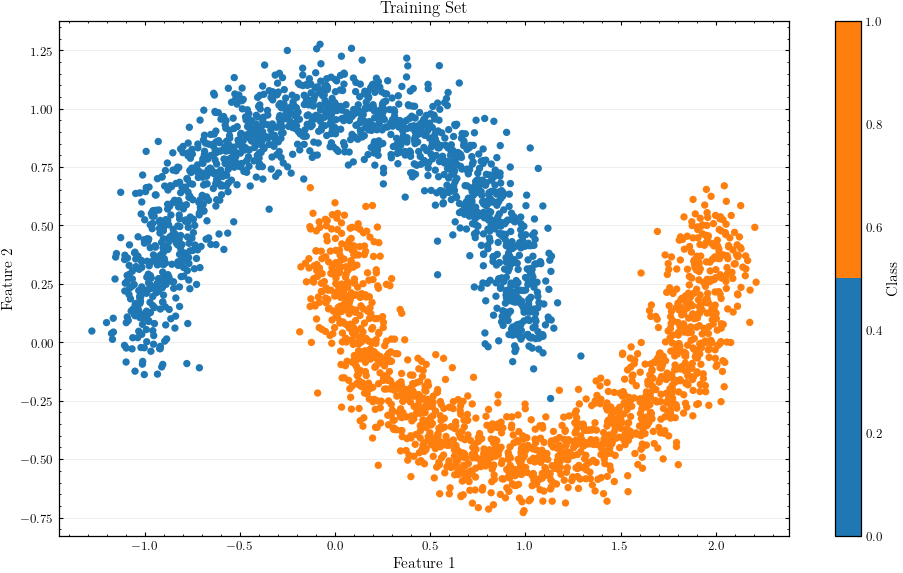

In [18]:
# Generate two moons dataset (via public dataset registry)
bundle = api.get_dataset("two_moons", config)
X_train, y_train = bundle.X_train, bundle.y_train
X_val, y_val = bundle.X_val, bundle.y_val
X_test, y_test = bundle.X_test, bundle.y_test

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Feature dimension: {X_train.shape[1]}")

# Visualize the dataset
fig, ax = plt.subplots(figsize=(10, 6))
plot_two_moons(X_train, y_train, title="Training Set", ax=ax)
plt.tight_layout()
plt.show()


Model architecture:
TwoMoonsMLP(
  (activation): ReLU()
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
)

Training model...
Epoch [10/100] Train Loss: 0.0061, Train Acc: 99.90%, Val Loss: 0.0071, Val Acc: 99.80%
Epoch [20/100] Train Loss: 0.0027, Train Acc: 99.93%, Val Loss: 0.0060, Val Acc: 99.80%
Epoch [30/100] Train Loss: 0.0020, Train Acc: 99.93%, Val Loss: 0.0049, Val Acc: 99.80%
Epoch [40/100] Train Loss: 0.0020, Train Acc: 99.93%, Val Loss: 0.0046, Val Acc: 99.80%
Early stopping at epoch 42


KeyboardInterrupt: 

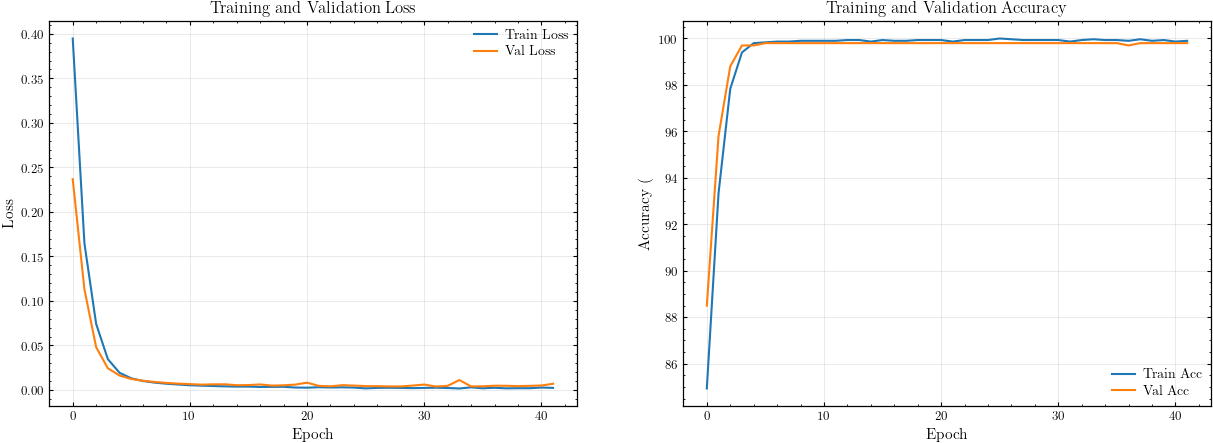

In [19]:
# Train model (API)
config.model.input_dim = int(X_train.shape[1])
config.model.output_dim = int(bundle.meta.get("num_classes", config.model.output_dim))

model = api.get_model(
    "MLP",
    config,
    input_dim=config.model.input_dim,
    output_dim=config.model.output_dim,
)

print("Model architecture:")
print(model)

print("\nTraining model...")
model, history = api.train(
    model,
    bundle,
    config,
    device=str(config.device),
    verbose=True,
    return_history=True,
)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history['train_loss'], label='Train Loss')
axes[0].plot(history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['train_acc'], label='Train Acc')
axes[1].plot(history['val_acc'], label='Val Acc')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Test Accuracy: 99.80%


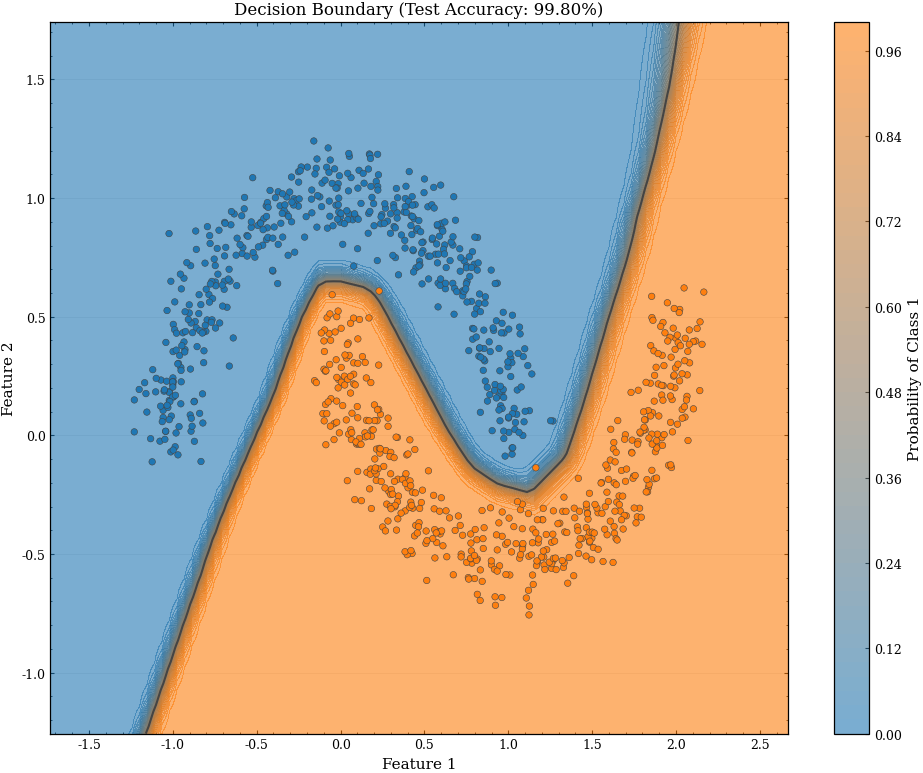

In [ ]:
# Evaluate on test set (API)
pred_test = api.predict(model, X_test, device=str(config.device), return_probs=False)
test_acc = 100.0 * float(np.mean(pred_test == np.asarray(y_test, dtype=int)))
print(f"Test Accuracy: {test_acc:.2f}%")

# Visualize decision boundary
fig, ax = plt.subplots(figsize=(10, 8))
plot_decision_boundary(
    model,
    X_test,
    y_test,
    title=f"Decision Boundary (Test Accuracy: {test_acc:.2f}%)",
    device=str(config.device),
    ax=ax,
)
plt.tight_layout()
plt.show()


## 5. Generate Adversarial Examples


Generating FGSM adversarial examples...
Attack success rate on validation set: 1.30%
Attack success rate on test set: 1.50%
Successful attacks in val: 13/1000
Successful attacks in test: 15/1000


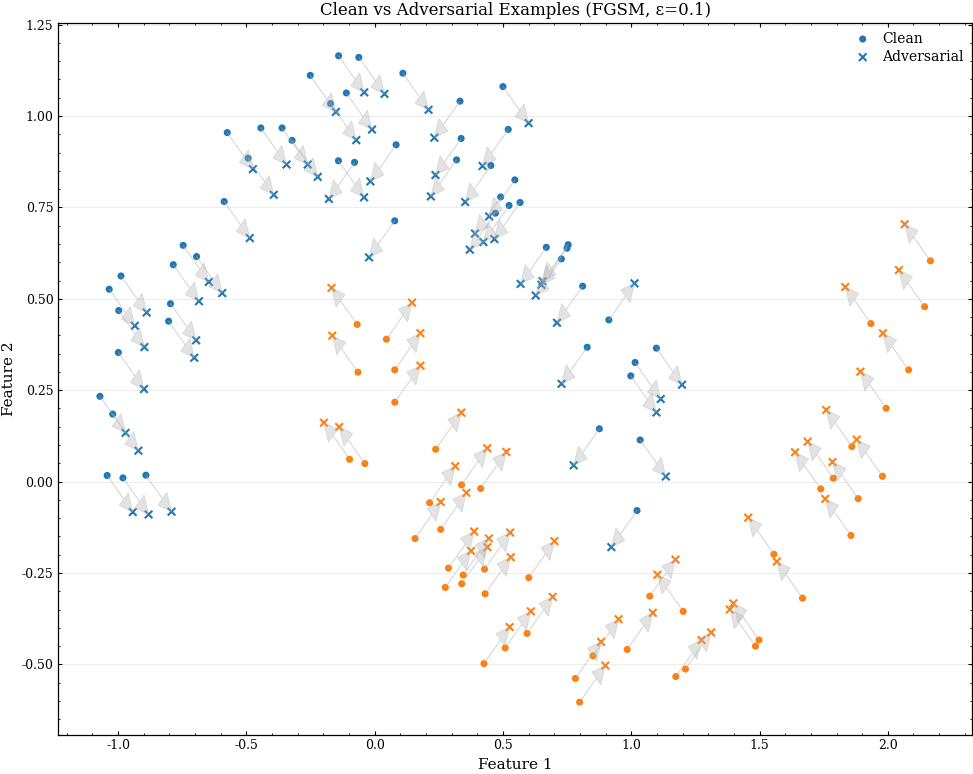

In [ ]:
# Generate adversarial examples (API)
print(f"Generating {config.attack.attack_type.upper()} adversarial examples...")
X_adv_val = api.generate_adversarial(model, X_val, y_val, config)
X_adv_test = api.generate_adversarial(model, X_test, y_test, config)

# Successful = model correct on clean AND wrong on adv
EVAL_ONLY_SUCCESSFUL_ATTACKS = True

val_success_mask = api.attack_success_mask(
    model,
    X_clean=X_val,
    X_adv=X_adv_val,
    y_true=y_val,
    device=str(config.device),
)
test_success_mask = api.attack_success_mask(
    model,
    X_clean=X_test,
    X_adv=X_adv_test,
    y_true=y_test,
    device=str(config.device),
)

val_success_rate = 100.0 * float(val_success_mask.mean())
test_success_rate = 100.0 * float(test_success_mask.mean())

print(f"Attack success rate on validation set: {val_success_rate:.2f}%")
print(f"Attack success rate on test set: {test_success_rate:.2f}%")
print(f"Successful attacks in val: {val_success_mask.sum()}/{len(val_success_mask)}")
print(f"Successful attacks in test: {test_success_mask.sum()}/{len(test_success_mask)}")

# Visualize adversarial examples
fig, ax = plt.subplots(figsize=(10, 8))
plot_adversarial_examples(
    X_test[:100],
    X_adv_test[:100],
    y_test[:100],
    title=f"Clean vs Adversarial Examples ({config.attack.attack_type.upper()}, ε={config.attack.epsilon})",
    n_samples=100,
    ax=ax,
)
plt.tight_layout()
plt.show()


## 6. Build Graph on Training Data


In [ ]:
# Training reference set used by scoring (kept for PH diagram visualization)
if config.graph.space == "feature":
    Z_train = extract_features_batch(model, X_train, layer="penultimate", device=str(config.device))
else:
    Z_train = X_train

print(f"Training representations shape: {Z_train.shape}")
print(f"Space: {config.graph.space}")

# Model outputs on the training set (used by some scoring variants)
logits_train = get_model_logits(model, X_train, device=str(config.device))
probs_train = torch.softmax(torch.as_tensor(logits_train, dtype=torch.float32), dim=1).cpu().numpy()
f_train = probs_train[:, 1]  # Probability of class 1

print(f"Training model outputs shape: {f_train.shape}")


Training representations shape: (3000, 32)
Space: feature
Training model outputs shape: (3000,)


## 7. Compute Graph-Based Scores


In [ ]:
# Compute scores (API)
print("Computing scores for clean validation set...")
scores_val_clean = api.compute_scores(X_val, model, bundle=bundle, cfg=config)

print("Computing scores for adversarial validation set...")
scores_val_adv = api.compute_scores(X_adv_val, model, bundle=bundle, cfg=config)

print("Computing scores for clean test set...")
scores_test_clean = api.compute_scores(X_test, model, bundle=bundle, cfg=config)

print("Computing scores for adversarial test set...")
scores_test_adv = api.compute_scores(X_adv_test, model, bundle=bundle, cfg=config)

print(f"\nScore keys computed: {list(scores_val_clean.keys())}")

# Sanity checks: make sure we computed what's needed for the chosen detector type
if config.detector.detector_type == "topology_score":
    topo_keys = [k for k in scores_val_clean.keys() if str(k).startswith("topo_")]
    if len(topo_keys) == 0:
        raise KeyError(
            "Topology detector requested, but no topo_* keys were computed. "
            "Make sure config.graph.use_topology = True and ripser is installed."
        )
    print(f"Topology keys available (n={len(topo_keys)}). Example: {topo_keys[:6]}")
else:
    if config.detector.score_type in scores_val_clean:
        print(f"Score shape: {scores_val_clean[config.detector.score_type].shape}")
    else:
        raise KeyError(
            f"Requested score_type={config.detector.score_type!r} not computed. "
            f"Available score keys: {list(scores_val_clean.keys())}. "
            "If you recently updated src/, restart the notebook kernel to reload modules."
        )


Computing scores for clean validation set...
Computing scores for adversarial validation set...
Computing scores for clean test set...
Computing scores for adversarial test set...

Score keys computed: ['degree', 'laplacian', 'tangent_residual', 'tangent_residual_z', 'knn_radius', 'topo_h0_count', 'topo_h0_entropy', 'topo_h0_l2_persistence', 'topo_h0_max_persistence', 'topo_h0_total_persistence', 'topo_h1_count', 'topo_h1_entropy', 'topo_h1_l2_persistence', 'topo_h1_max_persistence', 'topo_h1_total_persistence']
Topology keys available (n=10). Example: ['topo_h0_count', 'topo_h0_entropy', 'topo_h0_l2_persistence', 'topo_h0_max_persistence', 'topo_h0_total_persistence', 'topo_h1_count']


## 8. Visualize Score Distributions


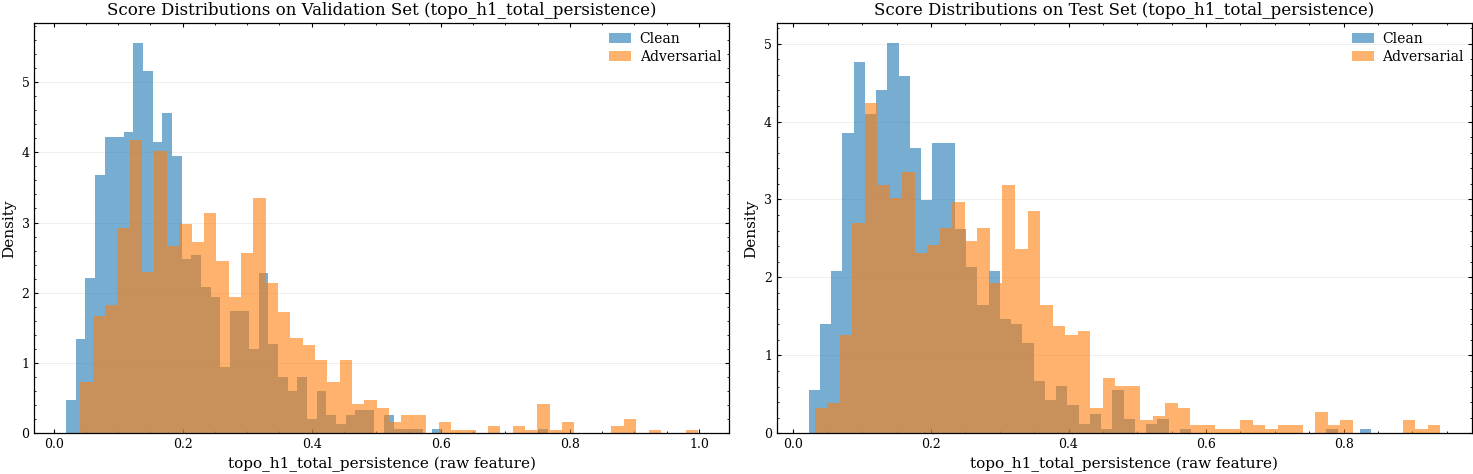

Clean - Mean: 0.1851, Std: 0.1028
Adversarial - Mean: 0.2571, Std: 0.1454


In [ ]:
# Plot score distributions
# In topology mode, we pick a representative topo_* key for visualization.
if config.detector.detector_type == 'topology_score':
    topo_keys_cfg = getattr(config.detector, 'topo_feature_keys', None) or []
    if len(topo_keys_cfg) > 0:
        score_type = topo_keys_cfg[0]
    elif 'topo_h1_total_persistence' in scores_val_clean:
        score_type = 'topo_h1_total_persistence'
    else:
        topo_keys = sorted([k for k in scores_val_clean.keys() if str(k).startswith('topo_')])
        score_type = topo_keys[0]
else:
    score_type = config.detector.score_type

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Validation set
plot_score_distributions(
    scores_val_clean[score_type],
    scores_val_adv[score_type],
    score_name=f"{score_type} (raw feature)",
    title=f"Score Distributions on Validation Set ({score_type})",
    ax=axes[0]
)

# Test set
plot_score_distributions(
    scores_test_clean[score_type],
    scores_test_adv[score_type],
    score_name=f"{score_type} (raw feature)",
    title=f"Score Distributions on Test Set ({score_type})",
    ax=axes[1]
)

plt.tight_layout()
plt.show()

print(f"Clean - Mean: {scores_val_clean[score_type].mean():.4f}, Std: {scores_val_clean[score_type].std():.4f}")
print(f"Adversarial - Mean: {scores_val_adv[score_type].mean():.4f}, Std: {scores_val_adv[score_type].std():.4f}")


## 9. Train and Evaluate Detector


Training detector...
Detector trained successfully!
ROC dataset size: n=1015 (clean=1000, adv=15)

Detector Performance (raw scores: topology_mahalanobis):
  ROC AUC: 0.9983
  PR AUC: 0.8092
  FPR @ 95% TPR: 0.0070

Detector Performance (trained detector @ 0.5 prob threshold):
  Accuracy: 0.9379
  Precision: 0.1923
  Recall: 1.0000
  F1: 0.3226


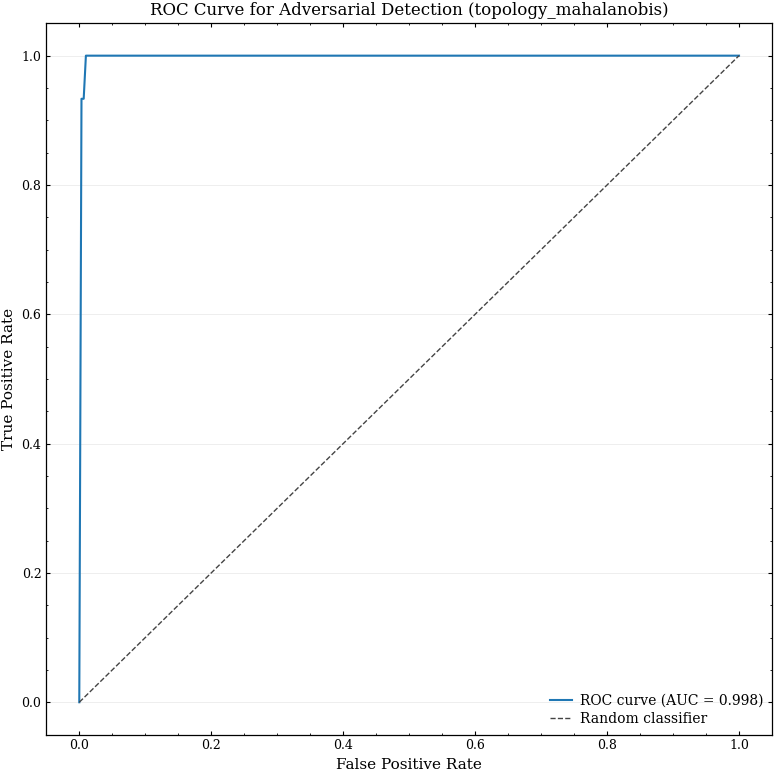


Confusion (detector.predict):
  TP=15  FP=63  TN=937  FN=0
  TPR=1.0000  FPR=0.0630


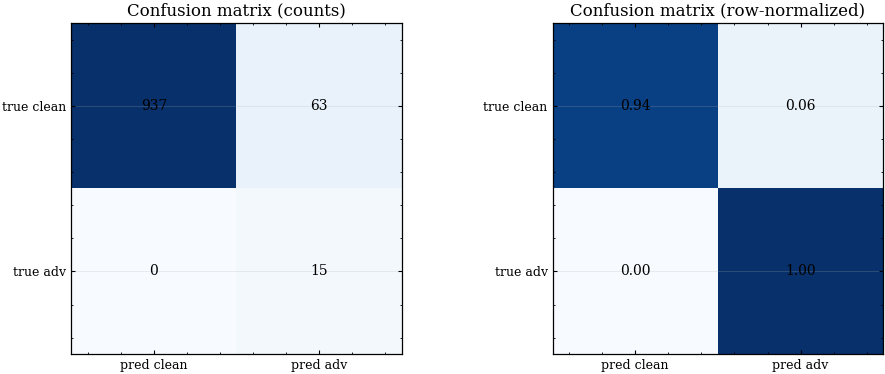

In [ ]:
# Prepare validation scores and labels for detector training
# Optionally restrict adversarial set to *successful* attacks (especially important at small eps)
if 'EVAL_ONLY_SUCCESSFUL_ATTACKS' in globals() and EVAL_ONLY_SUCCESSFUL_ATTACKS:
    adv_val_mask = val_success_mask
else:
    adv_val_mask = np.ones(len(X_adv_val), dtype=bool)

scores_val_adv_used = {k: np.asarray(v)[adv_val_mask] for k, v in scores_val_adv.items()}
scores_val_all = api.concat_scores(scores_val_clean, scores_val_adv_used)
any_key_val = next(iter(scores_val_all.keys()))
labels_val = np.concatenate([
    np.zeros(len(scores_val_clean[any_key_val]), dtype=int),
    np.ones(len(scores_val_adv_used[any_key_val]), dtype=int),
])

# Train detector on validation set (API)
print("Training detector...")
detector = api.fit_detector(scores_val_all, labels_val, config)
print("Detector trained successfully!")

# Evaluate on test set
if 'EVAL_ONLY_SUCCESSFUL_ATTACKS' in globals() and EVAL_ONLY_SUCCESSFUL_ATTACKS:
    adv_test_mask = test_success_mask
else:
    adv_test_mask = np.ones(len(X_adv_test), dtype=bool)

scores_test_adv_used = {k: np.asarray(v)[adv_test_mask] for k, v in scores_test_adv.items()}
scores_test_all = api.concat_scores(scores_test_clean, scores_test_adv_used)
any_key_test = next(iter(scores_test_all.keys()))
labels_test = np.concatenate([
    np.zeros(len(scores_test_clean[any_key_test]), dtype=int),
    np.ones(len(scores_test_adv_used[any_key_test]), dtype=int),
])

print(
    f"ROC dataset size: n={len(labels_test)} (clean={len(scores_test_clean[any_key_test])}, adv={len(scores_test_adv_used[any_key_test])})"
)

# Get detector predictions (thresholded) + probability proxy (API)
predictions_test, probs_test = api.detect(detector, scores_test_all)

# 1) Raw-score ranking performance (AUC)
raw_test_scores = np.asarray(detector.score(scores_test_all), dtype=float)
raw_score_name = 'topology_mahalanobis'
raw_metrics = api.evaluate_detection(labels_test, raw_test_scores)

# 2) The trained detector as a binary classifier (probability proxy)
trained_metrics = evaluate_detector(labels_test, probs_test, threshold=0.5)

print(f"\nDetector Performance (raw scores: {raw_score_name}):")
print(f"  ROC AUC: {raw_metrics['roc_auc']:.4f}")
print(f"  PR AUC: {raw_metrics['pr_auc']:.4f}")
print(f"  FPR @ 95% TPR: {raw_metrics['fpr_at_tpr95']:.4f}")

print(f"\nDetector Performance (trained detector @ 0.5 prob threshold):")
print(f"  Accuracy: {trained_metrics['accuracy']:.4f}")
print(f"  Precision: {trained_metrics['precision']:.4f}")
print(f"  Recall: {trained_metrics['recall']:.4f}")
print(f"  F1: {trained_metrics['f1']:.4f}")

# Plot ROC curve (raw score AUC)
fig, ax = plt.subplots(figsize=(8, 8))
plot_roc_curve(
    np.asarray(raw_metrics['fpr']),
    np.asarray(raw_metrics['tpr']),
    raw_metrics['roc_auc'],
    title=f"ROC Curve for Adversarial Detection ({raw_score_name})",
    ax=ax,
    interpolate=True,
    n_points=300,
)
plt.tight_layout()
plt.show()

# Confusion matrix (TP/FP/TN/FN) for the detector's binary decisions
# Note: predictions_test comes from the detector's own thresholding rule.
y_true = labels_test.astype(int)
y_pred = np.asarray(predictions_test, dtype=int)

tp = int(np.sum((y_true == 1) & (y_pred == 1)))
tn = int(np.sum((y_true == 0) & (y_pred == 0)))
fp = int(np.sum((y_true == 0) & (y_pred == 1)))
fn = int(np.sum((y_true == 1) & (y_pred == 0)))

tpr = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
fpr = fp / (fp + tn) if (fp + tn) > 0 else float('nan')

print("\nConfusion (detector.predict):")
print(f"  TP={tp}  FP={fp}  TN={tn}  FN={fn}")
print(f"  TPR={tpr:.4f}  FPR={fpr:.4f}")

cm = np.array([[tn, fp], [fn, tp]], dtype=float)
cm_norm = cm / (cm.sum(axis=1, keepdims=True) + 1e-12)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].imshow(cm, cmap='Blues')
axes[0].set_title('Confusion matrix (counts)')
axes[0].set_xticks([0, 1]); axes[0].set_yticks([0, 1])
axes[0].set_xticklabels(['pred clean', 'pred adv'])
axes[0].set_yticklabels(['true clean', 'true adv'])
for (i, j), val in np.ndenumerate(cm):
    axes[0].text(j, i, f"{int(val)}", ha='center', va='center')

axes[1].imshow(cm_norm, vmin=0, vmax=1, cmap='Blues')
axes[1].set_title('Confusion matrix (row-normalized)')
axes[1].set_xticks([0, 1]); axes[1].set_yticks([0, 1])
axes[1].set_xticklabels(['pred clean', 'pred adv'])
axes[1].set_yticklabels(['true clean', 'true adv'])
for (i, j), val in np.ndenumerate(cm_norm):
    axes[1].text(j, i, f"{val:.2f}", ha='center', va='center')

plt.tight_layout()
plt.show()


## 12. Visualize Detector Steps with PH Diagrams

This section visualizes the detector pipeline step-by-step, showing:
1. Local neighborhood point cloud
2. Persistence diagrams (H0 and H1)
3. Topology summary features
4. Final detector score

We'll compare a clean non-flagged sample with an adversarial flagged sample.

In [ ]:
# Import the helper function for computing scores with diagrams
from src.graph_scoring import compute_graph_scores_with_diagrams
from src.visualization import (
    plot_persistence_diagram, 
    plot_topology_summary_features, 
    plot_local_neighborhood
)

# Select examples for visualization
# 1. Clean non-flagged sample (low detector score)
clean_scores = detector.score(scores_test_clean)
clean_idx = np.argmin(clean_scores)  # Lowest score = most clean-like
# predictions_test is ordered as [clean_samples, adversarial_samples]
clean_pred_idx = clean_idx  # Index in predictions_test for clean sample
print(f"Selected clean sample: index {clean_idx}, score={clean_scores[clean_idx]:.4f}, flagged={predictions_test[clean_pred_idx]}")

# 2. Adversarial flagged sample (high detector score)
# IMPORTANT: `adv_test_mask` is defined on *X_adv_test* (original ordering).
# If we filtered to successful attacks earlier, we must score and index the same filtered set.
if adv_test_mask.sum() > 0:
    # Prefer the already-filtered dict (created in the detector/eval cell)
    if "scores_test_adv_used" in globals():
        adv_scores = detector.score(scores_test_adv_used)
        adv_idx = int(np.argmax(adv_scores))
        adv_global_idx = np.where(adv_test_mask)[0][adv_idx]
    else:
        # Fall back: explicitly filter scores_test_adv with adv_test_mask
        scores_test_adv_used = {k: np.asarray(v)[adv_test_mask] for k, v in scores_test_adv.items()}
        adv_scores = detector.score(scores_test_adv_used)
        adv_idx = int(np.argmax(adv_scores))
        adv_global_idx = np.where(adv_test_mask)[0][adv_idx]

    # Index in predictions_test: clean samples come first, then adversarial
    # (predictions_test/probs_test come from scoring `scores_test_all`)
    adv_pred_idx = len(scores_test_clean[score_type]) + adv_idx
    print(
        f"Selected adversarial sample: global index {adv_global_idx}, score={float(adv_scores[adv_idx]):.4f}, "
        f"flagged={predictions_test[adv_pred_idx]}"
    )
else:
    # If no successful attacks, pick the highest scoring clean sample
    adv_idx = int(np.argmax(clean_scores))
    adv_global_idx = adv_idx
    adv_pred_idx = adv_idx
    print(f"No successful attacks. Using highest scoring clean sample: index {adv_idx}, score={clean_scores[adv_idx]:.4f}")

# Compute scores with diagrams for both samples
print("\nComputing topology features with diagrams for clean sample...")
clean_features, clean_diagrams, clean_cloud = compute_graph_scores_with_diagrams(
    X_test[clean_idx], model, Z_train, f_train, config.graph, device=config.device
)

print("Computing topology features with diagrams for adversarial sample...")
if adv_test_mask.sum() > 0:
    adv_features, adv_diagrams, adv_cloud = compute_graph_scores_with_diagrams(
        X_adv_test[adv_global_idx], model, Z_train, f_train, config.graph, device=config.device
    )
else:
    # Use clean sample if no adversarial available
    adv_features, adv_diagrams, adv_cloud = clean_features, clean_diagrams, clean_cloud

# Get detector scores
clean_detector_score = clean_scores[clean_idx]
if adv_test_mask.sum() > 0:
    adv_detector_score = adv_scores[adv_idx]
else:
    adv_detector_score = clean_scores[adv_idx]

print(f"\nDetector scores:")
print(f"  Clean sample: {clean_detector_score:.4f} (threshold: {detector.threshold:.4f})")
print(f"  Adversarial sample: {adv_detector_score:.4f} (threshold: {detector.threshold:.4f})")

Selected clean sample: index 718, score=0.3387, flagged=0
Selected adversarial sample: global index 506, score=9.4387, flagged=1

Computing topology features with diagrams for clean sample...
Computing topology features with diagrams for adversarial sample...

Detector scores:
  Clean sample: 0.3387 (threshold: 3.3737)
  Adversarial sample: 9.4387 (threshold: 3.3737)


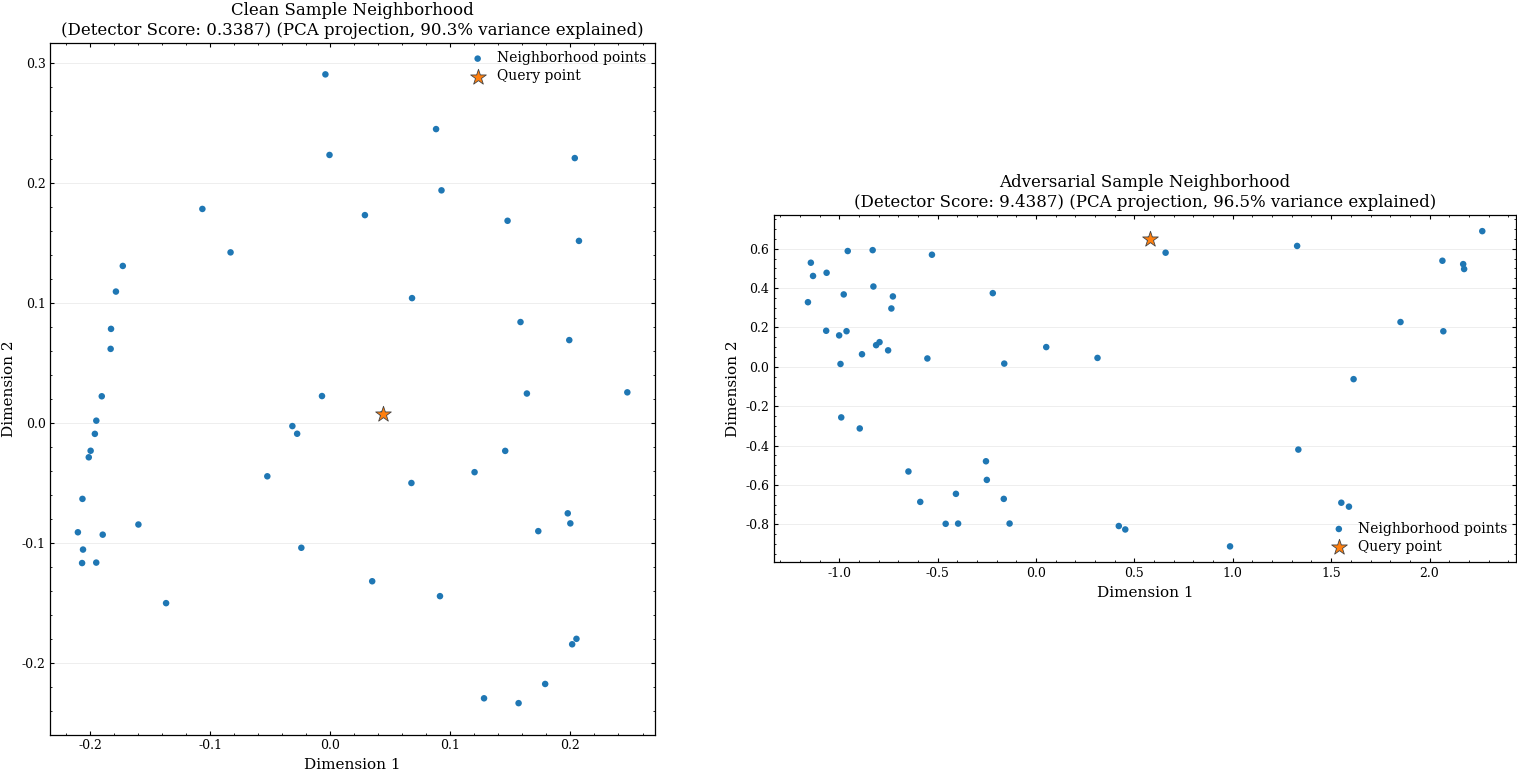

In [ ]:
# Visualize local neighborhood point clouds
# NOTE: this cell depends on the previous "compute ... with diagrams" cell.
# If you run cells out-of-order, recompute clouds/diagrams here.
if 'clean_cloud' not in globals() or 'adv_cloud' not in globals():
    print("clean_cloud/adv_cloud not found (likely ran out-of-order). Recomputing...")

    clean_features, clean_diagrams, clean_cloud = compute_graph_scores_with_diagrams(
        X_test[clean_idx], model, Z_train, f_train, config.graph, device=config.device
    )

    if adv_test_mask.sum() > 0:
        adv_features, adv_diagrams, adv_cloud = compute_graph_scores_with_diagrams(
            X_adv_test[adv_global_idx], model, Z_train, f_train, config.graph, device=config.device
        )
    else:
        adv_features, adv_diagrams, adv_cloud = clean_features, clean_diagrams, clean_cloud

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Clean sample neighborhood
plot_local_neighborhood(
    clean_cloud,
    query_point=clean_cloud[0] if len(clean_cloud) > 0 else None,
    title=f"Clean Sample Neighborhood\n(Detector Score: {clean_detector_score:.4f})",
    ax=axes[0],
    max_dims=2
)

# Adversarial sample neighborhood
plot_local_neighborhood(
    adv_cloud,
    query_point=adv_cloud[0] if len(adv_cloud) > 0 else None,
    title=f"Adversarial Sample Neighborhood\n(Detector Score: {adv_detector_score:.4f})",
    ax=axes[1],
    max_dims=2
)

plt.tight_layout()
plt.show()

ValueError: operands could not be broadcast together with shapes (51,) (50,) 

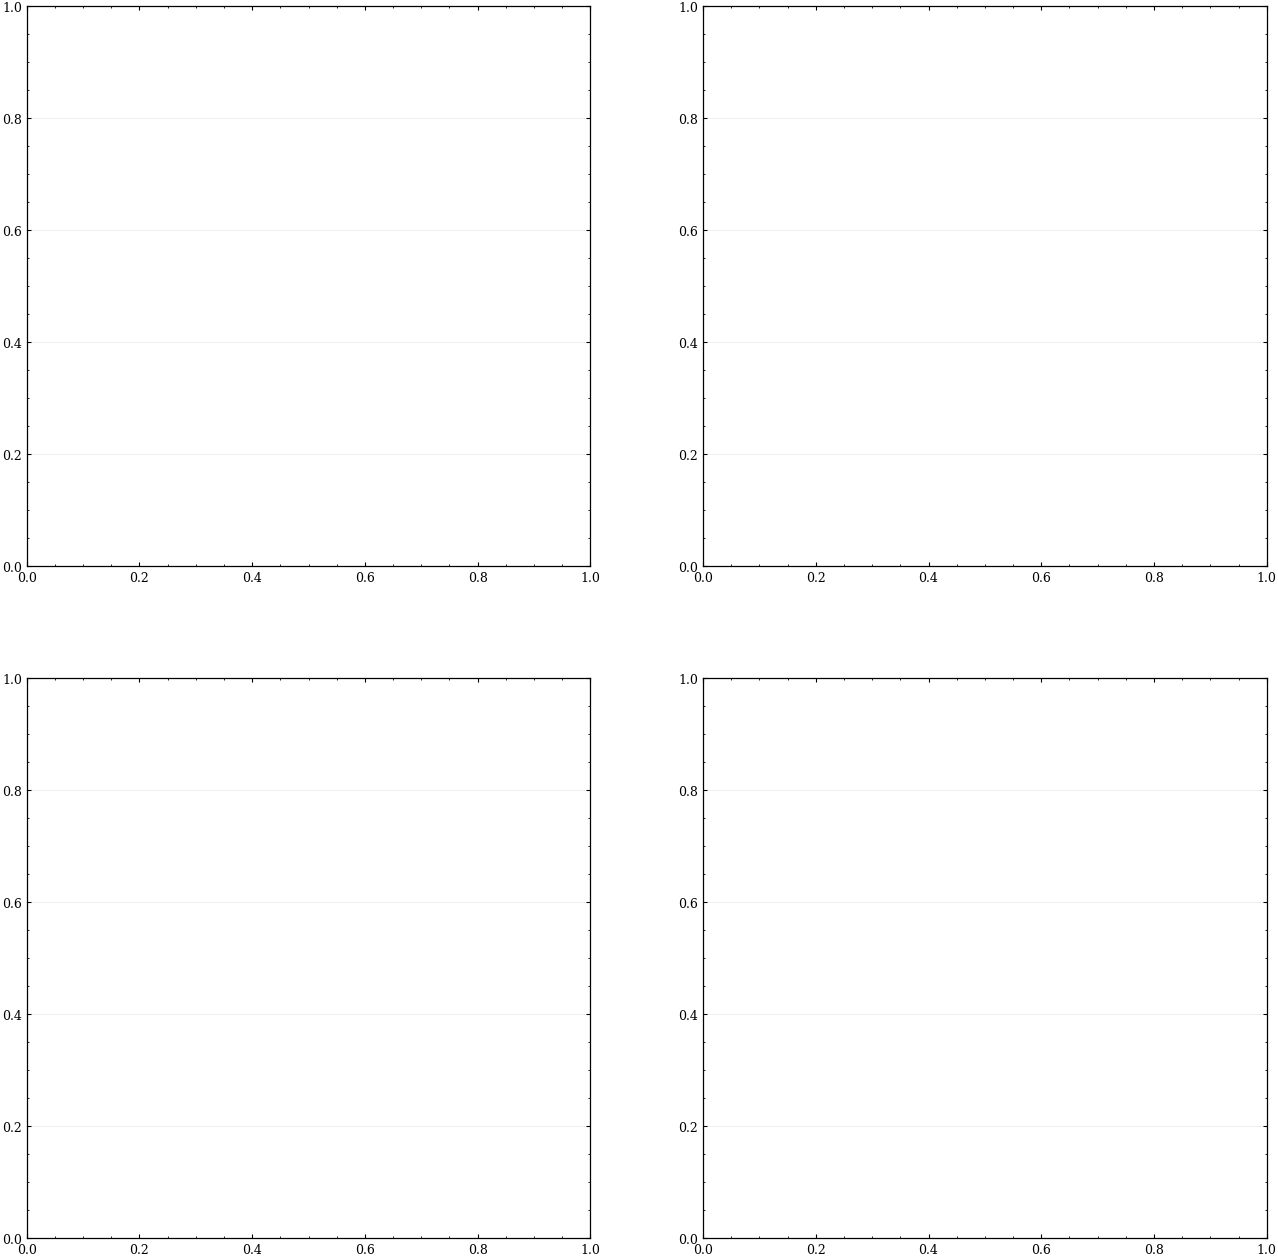

In [ ]:
# Visualize persistence diagrams (H0 and H1)
fig, axes = plt.subplots(2, 2, figsize=(16, 16))

# Clean sample H0
if len(clean_diagrams) > 0 and clean_diagrams[0].size > 0:
    plot_persistence_diagram(
        clean_diagrams[0],
        dimension=0,
        title=f"Clean Sample - H0 Persistence Diagram\n(Score: {clean_detector_score:.4f})",
        ax=axes[0, 0],
        min_persistence=config.graph.topo_min_persistence
    )
else:
    axes[0, 0].text(0.5, 0.5, 'No H0 features', ha='center', va='center', transform=axes[0, 0].transAxes)
    axes[0, 0].set_title(f"Clean Sample - H0 Persistence Diagram\n(Score: {clean_detector_score:.4f})")

# Clean sample H1
if len(clean_diagrams) > 1 and clean_diagrams[1].size > 0:
    plot_persistence_diagram(
        clean_diagrams[1],
        dimension=1,
        title=f"Clean Sample - H1 Persistence Diagram\n(Score: {clean_detector_score:.4f})",
        ax=axes[0, 1],
        min_persistence=config.graph.topo_min_persistence
    )
else:
    axes[0, 1].text(0.5, 0.5, 'No H1 features', ha='center', va='center', transform=axes[0, 1].transAxes)
    axes[0, 1].set_title(f"Clean Sample - H1 Persistence Diagram\n(Score: {clean_detector_score:.4f})")

# Adversarial sample H0
if len(adv_diagrams) > 0 and adv_diagrams[0].size > 0:
    plot_persistence_diagram(
        adv_diagrams[0],
        dimension=0,
        title=f"Adversarial Sample - H0 Persistence Diagram\n(Score: {adv_detector_score:.4f})",
        ax=axes[1, 0],
        min_persistence=config.graph.topo_min_persistence
    )
else:
    axes[1, 0].text(0.5, 0.5, 'No H0 features', ha='center', va='center', transform=axes[1, 0].transAxes)
    axes[1, 0].set_title(f"Adversarial Sample - H0 Persistence Diagram\n(Score: {adv_detector_score:.4f})")

# Adversarial sample H1
if len(adv_diagrams) > 1 and adv_diagrams[1].size > 0:
    plot_persistence_diagram(
        adv_diagrams[1],
        dimension=1,
        title=f"Adversarial Sample - H1 Persistence Diagram\n(Score: {adv_detector_score:.4f})",
        ax=axes[1, 1],
        min_persistence=config.graph.topo_min_persistence
    )
else:
    axes[1, 1].text(0.5, 0.5, 'No H1 features', ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title(f"Adversarial Sample - H1 Persistence Diagram\n(Score: {adv_detector_score:.4f})")

plt.tight_layout()
plt.show()

In [ ]:
# Visualize topology summary features
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Clean sample features
plot_topology_summary_features(
    clean_features,
    title=f"Clean Sample - Topology Summary Features\n(Detector Score: {clean_detector_score:.4f}, Threshold: {detector.threshold:.4f})",
    ax=axes[0]
)

# Adversarial sample features
plot_topology_summary_features(
    adv_features,
    title=f"Adversarial Sample - Topology Summary Features\n(Detector Score: {adv_detector_score:.4f}, Threshold: {detector.threshold:.4f})",
    ax=axes[1]
)

plt.tight_layout()
plt.show()

# Print feature comparison
print("\nTopology Feature Comparison:")
print("=" * 80)
for key in sorted(clean_features.keys()):
    clean_val = clean_features.get(key, 0.0)
    adv_val = adv_features.get(key, 0.0)
    diff = adv_val - clean_val
    print(f"{key:30s} Clean: {clean_val:8.4f}  Adversarial: {adv_val:8.4f}  Diff: {diff:8.4f}")
print("=" * 80)

## 10. Visualize Scores on Test Set


In [ ]:
# Visualize a representative score on the 2D test set
# (In feature-space experiments, this is still plotted against the 2D input for intuition.)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Clean test points colored by score
plot_score_scatter(
    X_test, scores_test_clean[score_type],
    title=f"Clean Test Points - {score_type} (raw feature)",
    cmap='viridis',
    ax=axes[0]
)

# Adversarial test points colored by score
plot_score_scatter(
    X_adv_test, scores_test_adv[score_type],
    title=f"Adversarial Test Points - {score_type} (raw feature)",
    cmap='viridis',
    ax=axes[1]
)

plt.tight_layout()
plt.show()


## 11. Calibrate Scores to Error Probabilities


In [ ]:
# Determine which predictions are wrong
pred_test_clean = get_model_predictions(model, X_test, device=config.device)
pred_test_adv = get_model_predictions(model, X_adv_test, device=config.device)

is_wrong_clean = (pred_test_clean != y_test).astype(int)
is_wrong_adv = (pred_test_adv != y_test).astype(int)

# Combine for calibration
# - For topology detector, calibrate the detector's topology score (Mahalanobis) rather than a single topo_* feature.
score_fn = getattr(detector, 'score', None)
if callable(score_fn):
    scores_clean_cal = np.asarray(score_fn(scores_test_clean), dtype=float)
    scores_adv_cal = np.asarray(score_fn(scores_test_adv), dtype=float)
    all_test_scores = np.concatenate([scores_clean_cal, scores_adv_cal])
else:
    all_test_scores = np.concatenate([scores_test_clean[score_type], scores_test_adv[score_type]])

all_is_wrong = np.concatenate([is_wrong_clean, is_wrong_adv])

# Calibrate scores to error probabilities
print("Calibrating scores to error probabilities...")
calibration_model = calibrate_error_probability(
    all_test_scores, all_is_wrong,
    method=config.detector.calibration_method
)

# Predict error probabilities
error_probs = predict_error_probability(
    calibration_model, all_test_scores,
    method=config.detector.calibration_method
)

# Compute calibration metrics
cal_metrics = compute_calibration_metrics(error_probs, all_is_wrong)
print(f"Expected Calibration Error (ECE): {cal_metrics['ece']:.4f}")
print(f"Max Calibration Error (MCE): {cal_metrics['mce']:.4f}")

# Plot calibration
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram of error probabilities
axes[0].hist(error_probs[all_is_wrong == 0], bins=20, alpha=0.5, label='Correct', density=True)
axes[0].hist(error_probs[all_is_wrong == 1], bins=20, alpha=0.5, label='Wrong', density=True)
axes[0].set_xlabel('Predicted Error Probability')
axes[0].set_ylabel('Density')
axes[0].set_title('Error Probability Distributions')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Reliability diagram
n_bins = 10
bin_boundaries = np.linspace(0, 1, n_bins + 1)
bin_lowers = bin_boundaries[:-1]
bin_uppers = bin_boundaries[1:]
bin_centers = (bin_lowers + bin_uppers) / 2

accuracies = []
confidences = []

for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
    in_bin = (error_probs > bin_lower) & (error_probs <= bin_upper)
    if in_bin.sum() > 0:
        accuracy = all_is_wrong[in_bin].mean()
        confidence = error_probs[in_bin].mean()
        accuracies.append(accuracy)
        confidences.append(confidence)
    else:
        accuracies.append(0)
        confidences.append(bin_centers[len(accuracies) - 1])

axes[1].plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
axes[1].plot(confidences, accuracies, 'o-', label='Calibrated model')
axes[1].set_xlabel('Mean Predicted Error Probability')
axes[1].set_ylabel('Actual Error Rate')
axes[1].set_title('Reliability Diagram')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 12. Error Probability Examples


In [ ]:
# Show examples of error probability predictions
print("Example predictions with error probabilities:\n")
print("=" * 80)

# Select a few examples from each category
n_examples = 5

# Clean examples with high error prob
clean_indices = np.where(all_is_wrong == 0)[0]
high_error_prob_clean = clean_indices[np.argsort(error_probs[clean_indices])[-n_examples:][::-1]]

# Wrong predictions
wrong_indices = np.where(all_is_wrong == 1)[0]
if len(wrong_indices) > 0:
    high_error_prob_wrong = wrong_indices[np.argsort(error_probs[wrong_indices])[-n_examples:][::-1]]
else:
    high_error_prob_wrong = []

print(f"\nTop {n_examples} clean examples with highest predicted error probability:")
for idx in high_error_prob_clean[:n_examples]:
    is_adv = "Adversarial" if idx >= len(X_test) else "Clean"
    point_idx = idx if idx < len(X_test) else idx - len(X_test)
    actual_label = y_test[point_idx]
    pred_label = pred_test_adv[point_idx] if idx >= len(X_test) else pred_test_clean[point_idx]
    score = all_test_scores[idx]
    err_prob = error_probs[idx]
    print(f"  {is_adv} point {point_idx}: True={actual_label}, Pred={pred_label}, "
          f"Score={score:.4f}, P(error)={err_prob:.4f}")

if len(high_error_prob_wrong) > 0:
    print(f"\nTop {n_examples} wrong predictions with highest error probability:")
    for idx in high_error_prob_wrong[:n_examples]:
        is_adv = "Adversarial" if idx >= len(X_test) else "Clean"
        point_idx = idx if idx < len(X_test) else idx - len(X_test)
        actual_label = y_test[point_idx]
        pred_label = pred_test_adv[point_idx] if idx >= len(X_test) else pred_test_clean[point_idx]
        score = all_test_scores[idx]
        err_prob = error_probs[idx]
        print(f"  {is_adv} point {point_idx}: True={actual_label}, Pred={pred_label}, "
              f"Score={score:.4f}, P(error)={err_prob:.4f}")

print("\n" + "=" * 80)
